In [92]:
import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns


sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': False
}
mpl.rcParams.update(params)


In [2]:
from helpers import colors, human_format

from datetime import datetime, timedelta
from os.path import expanduser
import pandas as pd
import numpy as np

cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web"]

## Videos per Community

1. We create a dataframe where we perform the analyses.

In [54]:
df_sources = pd.read_csv("../data/sources_final.csv")
df_list = []

for _, tmp in df_sources.iterrows():
    tmp = dict(tmp)
    if tmp["Category"] not in cats:
        continue
        
    # Reads metadata from youtube data
    df_tmp = pd.read_csv("../data/yt/{}.csv".format(tmp['Id']))

    # Gets upload date in datetime format
    upload_date = [
        datetime.strptime(str(v), "%Y%m%d")
        for v in df_tmp["upload_date"].values
    ]
    
    # Gets upload year in datetime format
    upload_year = [
        datetime.strptime(str(v)[:-4], "%Y")
        for v in df_tmp["upload_date"].values
    ]
    
    upload_month = [
        datetime.strptime(str(v)[:-2], "%Y%m")
        for v in df_tmp["upload_date"].values
    ]
        


    # Gets view and like count
    view_count = list(df_tmp["view_count"].values)
    like_count = list(df_tmp["like_count"].values)
    category = tmp["Category"]
    
    if category == "Alt-right":
        td = 50 + 32.5
    elif category == "Alt-lite":
        td = 150 + 32.5
    else:
        td = 250 + 32.5
        
    df_list += [{
        "category": category,
        "name": tmp["Name"],
        "upload_date": u,
        "upload_month": um,
        "upload_year": uy + timedelta(days=td),
        "upload_date_ts": u.timestamp(),
        "view_count": v,
        "like_count": l
    } for (u, um, uy, v, l) in zip(upload_date, upload_month, upload_year, view_count, like_count)
      if uy.year < 2019 and uy.year > 2007
    ]

df = pd.DataFrame(df_list)
df["dummy"] = 1    # Dummy variable will be useful for plots
df.loc[df.category == "Alt-right", "style"] = "x"
df.loc[df.category == "Alt-lite", "style"] = "o"
df.loc[df.category == "Intellectual Dark Web", "style"] = "s"

- Secondly, we create some plots with posting activity as well as likes and views accross the years.

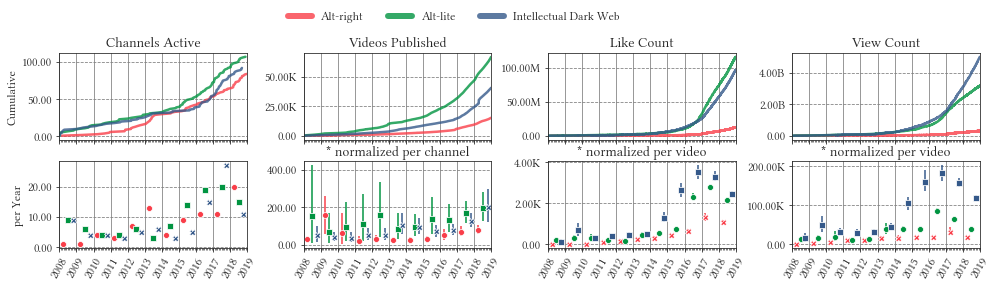

In [93]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(16.5, 4.5),
)
gs = fig.add_gridspec(nrows=2, ncols=4, wspace=0.3, hspace=0.25, top=0.90)

# adds subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[1, 1], sharex=ax2)
ax7 = fig.add_subplot(gs[1, 2], sharex=ax3)
ax8 = fig.add_subplot(gs[1, 3], sharex=ax3)

# auxiliary vars
qts = [ lambda x: np.cumsum(len(x) * [1]), 
       lambda x: np.cumsum(len(x) * [1]),
    lambda x: np.cumsum(x.like_count),
    lambda x: np.cumsum(x.view_count)
]

dfs = [df.groupby(["name", "category"]).min().reset_index(), df, df, df]
upper_tts = ["Channels Active", "Videos Published", "Like Count", "View Count"]
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
ys = ["dummy", "dummy", "like_count", "view_count"]
ests =  ["sum", "mean", "mean", "mean"]


# Plots cdfs on the top plots
for ax, qt, tt, _df  in zip(axs[:4], qts, upper_tts, dfs):
    max_v, min_v, max_cat = 0, 1, {}

    # Gets maximum value for category
    for cat in cats:
        df_tmp = _df.loc[_df.category == cat].sort_values("upload_date_ts")
        quantity = qt(df_tmp)
        max_v = max(max_v, max(quantity))
        max_cat[cat] = max(quantity)

    # Plot cdfs
    for cat in cats:
        df_tmp = _df.loc[_df.category == cat].sort_values("upload_date_ts")
        time = df_tmp.upload_date.values
        quantity = qt(df_tmp)
        quantity_p = quantity / max_cat[cat]
        
        if tt == "Like Count":
            ax.plot(time, quantity, "-", alpha=0.8, linewidth=2.5,
                    color=colors[cat], label=cat)
        else:
            ax.plot(time, quantity, "-", alpha=0.8, linewidth=2.5,
                    color=colors[cat])
    
    # Sets ticks, titles and limits
    ax.set_title(tt)
#     ax.set_ylim([0, 1])
#     ax.set_yticks([.25, .5, .75, 1])
#     ax.set_yticklabels(["25%", "50%", "75%", "100%"])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xlim([datetime(2008, 1, 1), datetime(2019, 1, 1)])
    
dfs = [df.groupby(["name", "category"]).min().reset_index(),
       df.groupby(["name", "category", "style", "upload_year"]).sum().reset_index(), 
       df, df]

# Adds legend on the top
leg = ax3.legend(loc='upper center',
           bbox_to_anchor=(-0.5, 1.6),
           ncol=3,
           fancybox=False,
           shadow=False,
           frameon=False,
           edgecolor=None,
           fontsize=12)



for line in leg.get_lines():
    line.set_linewidth(6.0)
    
# Plots yearly stuff on the bottom plots
for ax, y, est, _df in zip(axs[4:], ys, ests, dfs):

    sns.lineplot(x="upload_year", y=y, hue="category",  markers=True, err_style="bars", style="style",
        hue_order=["Alt-right", "Alt-lite", "Intellectual Dark Web"],
        palette=[colors[cat] for cat in ["Alt-right", "Alt-lite", "Intellectual Dark Web"]],
        data=_df, ax=ax, estimator=est, lw=0, solid_capstyle="butt")
    ax.get_legend().remove()

# Common axis config, grids, etc
for ax in axs:
    ax.xaxis.set_major_locator(matdates.YearLocator())
    ax.xaxis.set_minor_locator(matdates.MonthLocator())
    ax.xaxis.grid(color='gray', linestyle='solid')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.set_major_formatter(matdates.DateFormatter('%Y'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))
    ax.xaxis.set_tick_params(rotation=60)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Adds labels
_ = ax1.set_ylabel("Cumulative")
_ = ax5.set_ylabel("per Year")
_ = ax6.set_title("* normalized per channel")
_ = ax7.set_title("* normalized per video")
_ = ax8.set_title("* normalized per video")

# Saves figs
fig.savefig("../imgs/overview.pdf", bbox_inches='tight')
fig.savefig("../imgs/overview.png", bbox_inches='tight')

## Top Channels Table

- Makes nice table with top channels

In [ ]:
tmp = {}
tmp_helper = []
for idx, cat in enumerate(cats):
    df_cat_sum = df.loc[df.category == cat].groupby(["name"]).sum()
    names = df_cat_sum.sort_values("view_count", ascending=False).head(16).index.values
    tmp[cat] = names
    tmp_helper += [{"category": c, "name": n, "pos": p} 
                   for c, n, p in zip([cat]*len(names), names, np.arange(16)+1)]
            
    tmp["View Count" + " "*idx] = [
        human_format(num) for num in df_cat_sum.sort_values(
            "view_count", ascending=False).head(16).view_count.values
    ]
    
df_helper = pd.DataFrame(tmp_helper)
df_helper.to_csv("../data/important_channels.csv", index=False)

df_table = pd.DataFrame(tmp)
df_table.index += 1
df_table
# print(df_table.to_latex())